# AutoEncoder教學筆記本
Autoencoder也稱自動編碼器，是一種對稱結構類神經網絡，在無監督學習中，主要用於編碼。自動編碼器的目的是數據學習出一種表示方式。

## AutoEncoder 常被用於：
* 降維：當資料維度過大時，可以藉由自動編碼器(AutoEncoder)剔除相關度較小的欄位，以此達成資料降維的任務。
* 除錯：當資料經AutoEncoder學習後可以確保原始資料被壓縮至一定限度的分佈，當輸入資料經自動編碼器(AutoEncoder)處理後，若超出標準距離就可以定義該筆資料為異常的資料。

在這本筆記本中，將學習自動編碼器(AutoEncoder)的基本概念。我們將利用手寫數字資料集MNIST進行訓練，讓自動編碼器(AutoEncoder)學習MNIST資料集之特徵，並壓縮至3維(3D)空間。

![GAN](./utils/notebook_pic/autoencoder.png)


## 程式語言及相關的Library
* Python 
* Numpy
* Pytorch
* matplotlib

# 1. 導入相關的Library

In [1]:
%matplotlib inline

import os
import torch
import torchvision
from torch.autograd import Variable
import numpy as np
import itertools
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# 2. 導入 MNIST資料集
簡介：MNIST資料集是由Yann LeCun收集而成，資料集包含圖片與標籤。在其中，訓練資料一共有60000筆，而測試資料共10000筆。每一筆資料的照片是由 28像素 x 28像素，總共 784 個 pixels 所組成，圖片顯示的是0到9之中的一個阿拉伯數字。資料的標籤則表示該手寫數字圖片所呈現的數字為何，也就是 0 到 9 中一個數字。
![MNIST](./utils/notebook_pic/MNIST.jpeg)


In [2]:
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 3. 定義生成網路、監督網路
## 生成網路：
生成網路的目標是要偽造圖片，輸入至生成網路是一個隨機數。根據不同的隨機輸入數輸出不同的圖片，而若是生成網路訓練地非常完美，生成網路就可以不斷地輸出跟真實手寫數字相差無幾的圖片。
## 監督網路：
監督網路的目標就是要分辨資料的來源，給監督網路一張手寫圖片，計算出「相似度」的分數，分數越高則表示這張手寫圖片是來自真的資料集，反之則是由生成網路偽造的。



In [3]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),   
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder().cuda()
print("自動編碼器之結構 ： ")
print(autoencoder)

自動編碼器之結構 ： 
AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


# 4. 設定訓練細節
* 訓練次數 : 預設為50
* 設定Loss function : 預設為Mean-Square-Error Loss
* 設定Optimizer : 預設為Adam

In [4]:
import torch.optim as optim
EPOCH = 50
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
loss_func = nn.MSELoss()
view_data = Variable(train_dataset.train_data[:5].view(-1, 28*28).type(torch.FloatTensor)/255.).cuda()

# 5. 進行訓練

Epoch:  0 | train loss: 0.2315


/home/viplab/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


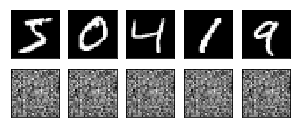

Epoch:  5 | train loss: 0.0378


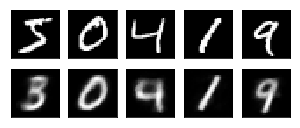

Epoch:  10 | train loss: 0.0369


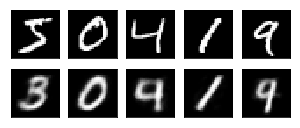

Epoch:  15 | train loss: 0.0369


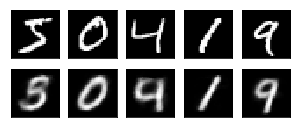

Epoch:  20 | train loss: 0.0335


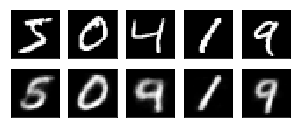

Epoch:  49 | train loss: 0.0338


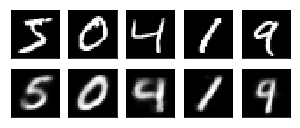

In [5]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28)).cuda()   
        b_y = Variable(x.view(-1, 28*28)).cuda()    
        b_label = Variable(y)               
        #輸入圖片並進行解碼、編碼
        _,decoded = autoencoder(b_x)
        #計算解碼輸出及圖片差異
        loss = loss_func(decoded, b_y)   
        #調整網路權重
        optimizer.zero_grad()
        loss.backward()                    
        optimizer.step()                   
        #每500步輸出當前訓練結果
        if step % 5000 == 0 and epoch in [0,5,10,15,20,EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])

            # plotting decoded image (second row)
            _,decoded_data = autoencoder(view_data)
            decoded_data = decoded_data.data.cpu()
            # initialize figure
            f, a = plt.subplots(2, 5, figsize=(5, 2))
            
            view_data_temp = view_data.data.cpu()
            for i in range(5):
                a[0][i].imshow(np.reshape(view_data_temp.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(5):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)

# 6. 輸出AutoEncoder壓縮成果

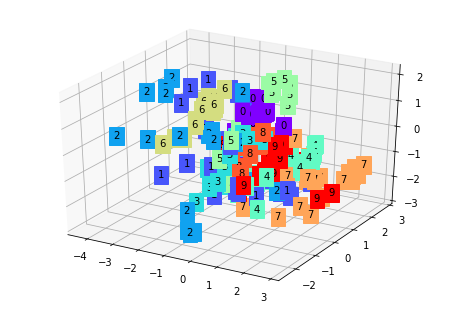

In [7]:
view_data = Variable(train_dataset.train_data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.).cuda()
encoded_data, _ = autoencoder(view_data)
encoded_data = encoded_data.data.cpu()
fig = plt.figure(2); ax = Axes3D(fig)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_dataset.train_labels[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()